## **Install BiaPy**
___
This might take some minutes depending on the current installed libraries in Colab.

In [1]:
#@markdown ##Play to install BiaPy and its dependences

import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from skimage.io import imread
import ipywidgets as widgets
from ipywidgets import Output

# Uninstall some packages already installed in Colab for Pytorch 2.1.0
!pip uninstall -y torchtext

!pip install biapy==3.5.5

# Then install Pytorch + CUDA 11.8
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu118
!pip install 'timm>=0.9.12' torchmetrics[image] pytorch-msssim

from biapy import BiaPy

changed_source = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.7/368.7 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.0/203.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/6

# **2D Semantic Segmentation pipeline**
___  
  
In this notebook, we show how to apply a [BiaPy](https://biapyx.github.io/) pipeline for **2D semantic segmentation** of microscopy data.

<figure>
<center>
<img src='https://biapy.readthedocs.io/en/latest/_images/lucchi_test_0.png' width='300px'/>
<img src='https://biapy.readthedocs.io/en/latest/_images/lucchi_test_0_gt.png' width='300px'/>
<figcaption><b>Figure 1</b>: Example of a 2D semantic segmentation problem. From left to right: 2D electron microscopy image and its corresponding mitochondria semantic labels.</figcaption></center>
</figure>

**Without any coding**, we explain step by step how to:
1. **Upload a set of training and test images** along with their corresponding semantic label images.
2. **Train a Deep Neural Network (DNN)** model using the training set.
3. **Apply the model** to the test images.
4. **Download the segmentation results** to your local machine.

**Disclaimer:** The structure of the notebook is heavily inspired by the fantastic [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

**Contact:** This notebook was created by [Ignacio Arganda-Carreras](mailto:ignacio.arganda@ehu.eus), [Lenka Backová](mailto:lenka.backova@ehu.eus), [Daniel Franco-Barranco](mailto:daniel.franco@dipc.org) and [Ane Paniagua](mailto:anepaniagua@gmail.com). For suggestions, comments, or issues, please reach out to us via email or [create an issue in BiaPy's repository](https://github.com/BiaPyX/BiaPy/issues). Thank you!

## **Expected Inputs and Outputs**
___

### **Inputs**

This notebook anticipates the following five folders as input:

- **Training Raw Images**: Contains the unprocessed 2D images used to train the model.
- **Training Label Images**: Contains the 2D semantic label images for training. Ensure the number and dimensions match the training raw images.
- **Test Raw Images**: Contains the 2D images to evaluate the model's performance.
- **Test Label Images**: Contains the 2D semantic label images for testing. Again, ensure their count and sizes align with the test raw images.
- **Output Folder**: A designated path to save the segmentation outcomes.

### **Outputs**

Upon successful execution, a directory will be generated with the segmentation results. Both probability maps and label images will be available for download at the notebook's conclusion.

<font color='red'><b>Note:</b></font> For testing purposes, you can use the **example dataset provided under 'Manage File(s) Source > Option 3'**.

**Data structure**

To ensure the proper operation of the library the data directory tree should be something like this:

```
dataset/
├── train
│   ├── x
│   │   ├── training-0001.tif
│   │   ├── training-0002.tif
│   │   ├── . . .
│   │   ├── training-9999.tif
│   └── y
│       ├── training_groundtruth-0001.tif
│       ├── training_groundtruth-0002.tif
│       ├── . . .
│       ├── training_groundtruth-9999.tif
└── test
    ├── x
    │   ├── testing-0001.tif
    │   ├── testing-0002.tif
    │   ├── . . .
    │   ├── testing-9999.tif
    └── y
        ├── testing_groundtruth-0001.tif
        ├── testing_groundtruth-0002.tif
        ├── . . .
        ├── testing_groundtruth-9999.tif
```

**⚠️ Warning:** Ensure that images and their corresponding masks are sorted in the same way. A common approach is to fill with zeros the image number added to the filenames (as in the example).

**Input Format Support**

This notebook is compatible with a range of input formats. You can use the following file extensions: `.tif`, `.png`, `.jpg`, `.npy`, `.h5`, `.hdf5` (every extension supported by [scikit-image](https://scikit-image.org/docs/stable/api/skimage.io.html#skimage.io.imread)).


## **Prepare the environment**
___

Establish connection with Google services. You **must be logged in to Google** to continue.
Since this is not Google's own code, you will probably see a message warning you of the dangers of running unfamiliar code. This is completely normal.


## **Check for GPU Access**
---

By default, the session is configured to use Python 3 with GPU acceleration. However, it's a good practice to double-check these settings:

1. Navigate to **Runtime** in the top menu and select **Change runtime type**.
2. Ensure the following settings:
   - **Runtime type:** Python 3 (This program is written in the Python 3 programming language.)
   - **Hardware accelerator:** select one of the GPU (Graphics Processing Unit) options available.

This will ensure that you're using Python 3 and taking advantage of GPU acceleration.

## **Manage File(s) Source**
---

The input folder can be provided using three different options:
1. **Direct Upload**: Directly upload the desired folder.
2. **Google Drive**: Use a folder stored in your Google Drive.
3. **Sample Data**: Use a sample dataset provided by us.

The steps you'll need to follow vary depending on your chosen option. These steps are detailed in the subsequent sections.

### **Option 1: Upload Local Files to the Notebook**
---
You will be prompted to upload your files to Colab and they will be stored under `/content/input/`.

In [16]:
#@markdown ##Play the cell to upload local files (train raw images)
from google.colab import files
!mkdir -p /content/input/train/x
%cd /content/input/train/x
uploaded = files.upload()
%cd /content

[03:00:05.336456] /content/input/train/x


[03:01:59.259911] Saving 0065.png to 0065 (1).png
[03:01:59.261634] Saving 0064.png to 0064 (1).png
[03:01:59.262754] Saving 0063.png to 0063 (1).png
[03:01:59.263987] Saving 0062.png to 0062 (1).png
[03:01:59.265116] Saving 0061.png to 0061 (1).png
[03:01:59.266185] Saving 0060.png to 0060 (1).png
[03:01:59.267245] Saving 0059.png to 0059 (1).png
[03:01:59.268278] Saving 0058.png to 0058 (1).png
[03:01:59.269330] Saving 0057.png to 0057 (1).png
[03:01:59.270378] Saving 0056.png to 0056 (1).png
[03:01:59.271416] Saving 0055.png to 0055 (1).png
[03:01:59.272437] Saving 0054.png to 0054 (1).png
[03:01:59.273525] Saving 0053.png to 0053 (1).png
[03:01:59.274656] Saving 0052.png to 0052 (1).png
[03:01:59.275799] Saving 0051.png to 0051 (1).png
[03:01:59.276958] Saving 0050.png to 0050 (1).png
[03:01:59.278002] Saving 0049.png to 0049 (1).png
[03:01:59.279137] Saving 0048.png to 0048 (1).png
[03:01:59.280190] Saving 0047.png to 0047 (1).png
[03:01:59.281253] Saving 0046.png to 0046 (1).png


In [3]:
#@markdown ##Play the cell to upload local files (train label images)

from google.colab import files
!mkdir -p /content/input/train/y
%cd /content/input/train/y
uploaded = files.upload()
%cd /content

/content/input/train/y


Saving 0065.png to 0065.png
Saving 0064.png to 0064.png
Saving 0063.png to 0063.png
Saving 0062.png to 0062.png
Saving 0061.png to 0061.png
Saving 0060.png to 0060.png
Saving 0059.png to 0059.png
Saving 0058.png to 0058.png
Saving 0057.png to 0057.png
Saving 0056.png to 0056.png
Saving 0055.png to 0055.png
Saving 0054.png to 0054.png
Saving 0053.png to 0053.png
Saving 0052.png to 0052.png
Saving 0051.png to 0051.png
Saving 0050.png to 0050.png
Saving 0049.png to 0049.png
Saving 0048.png to 0048.png
Saving 0047.png to 0047.png
Saving 0046.png to 0046.png
Saving 0045.png to 0045.png
Saving 0044.png to 0044.png
Saving 0043.png to 0043.png
Saving 0042.png to 0042.png
Saving 0041.png to 0041.png
Saving 0040.png to 0040.png
Saving 0039.png to 0039.png
Saving 0038.png to 0038.png
Saving 0037.png to 0037.png
Saving 0036.png to 0036.png
Saving 0035.png to 0035.png
Saving 0034.png to 0034.png
Saving 0033.png to 0033.png
Saving 0032.png to 0032.png
Saving 0031.png to 0031.png
Saving 0030.png to 0

In [4]:
#@markdown ##Play the cell to upload local files (test raw images)

from google.colab import files
!mkdir -p /content/input/test/x
%cd /content/input/test/x
uploaded = files.upload()
%cd /content

/content/input/test/x


Saving 0022.png to 0022.png
Saving 0021.png to 0021.png
Saving 0020.png to 0020.png
Saving 0019.png to 0019.png
Saving 0018.png to 0018.png
Saving 0017.png to 0017.png
Saving 0016.png to 0016.png
Saving 0015.png to 0015.png
Saving 0014.png to 0014.png
Saving 0013.png to 0013.png
Saving 0012.png to 0012.png
Saving 0011.png to 0011.png
Saving 0010.png to 0010.png
Saving 0009.png to 0009.png
Saving 0008.png to 0008.png
Saving 0007.png to 0007.png
Saving 0006.png to 0006.png
Saving 0005.png to 0005.png
Saving 0004.png to 0004.png
Saving 0003.png to 0003.png
Saving 0002.png to 0002.png
Saving 0001.png to 0001.png
Saving 0000.png to 0000.png
/content


In [5]:
#@markdown ##Play the cell to upload local files (test label images)

from google.colab import files
!mkdir -p /content/input/test/y
%cd /content/input/test/y
uploaded = files.upload()
%cd /content

/content/input/test/y


Saving 0022.png to 0022.png
Saving 0021.png to 0021.png
Saving 0020.png to 0020.png
Saving 0019.png to 0019.png
Saving 0018.png to 0018.png
Saving 0017.png to 0017.png
Saving 0016.png to 0016.png
Saving 0015.png to 0015.png
Saving 0014.png to 0014.png
Saving 0013.png to 0013.png
Saving 0012.png to 0012.png
Saving 0011.png to 0011.png
Saving 0010.png to 0010.png
Saving 0009.png to 0009.png
Saving 0008.png to 0008.png
Saving 0007.png to 0007.png
Saving 0006.png to 0006.png
Saving 0005.png to 0005.png
Saving 0004.png to 0004.png
Saving 0003.png to 0003.png
Saving 0002.png to 0002.png
Saving 0001.png to 0001.png
Saving 0000.png to 0000.png
/content


In [6]:
#@markdown #####Path to training input images
train_data_path = '/content/input/train/x' #@param {type:"string"}
#@markdown #####Path to training label images
train_data_gt_path = '/content/input/train/y' #@param {type:"string"}
#@markdown #####Path to test input images
test_data_path = '/content/input/test/x' #@param {type:"string"}
#@markdown #####Path to test label images (if available)
test_data_gt_path = '/content/input/test/y' #@param {type:"string"}
#@markdown #####Path to store the resulting images (it'll be created if not existing):
output_path = '/content/output' #@param {type:"string"}

## **Dataset Visualization**
___

In [7]:
# @markdown ## Play to visualize some data samples
# @markdown Select the *Set* (training or test) to visualize samples from, and use the *Image index* scroll to navigate among samples.

# @markdown **Note**: it might take a few seconds to refresh the images.


%matplotlib inline
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
import os
from ipywidgets import interact, IntSlider, Layout, Dropdown, HBox, Output

# Initialize paths and image IDs
input_path = train_data_path
gt_path = train_data_gt_path

ids_input = sorted(next(os.walk(input_path))[2])
ids_gt = sorted(next(os.walk(gt_path))[2])

# Dropdown widget to choose training or test set
dropdown = Dropdown(
    options=['training-set', 'test-set'],
    value='training-set',
    description='Set:',
    disabled=False,
)

# Slider widget to choose instance
slider= IntSlider(
    value=0,
    min=1,
    max=len(ids_input),
    step=1,
    description='Image index:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    layout=Layout(width='500px', margin = '0 0 0 10px')
)

slider.style.description_width = 'initial'
slider.style.handle_color='blue'

# Initialize Output instance to handle code output cell
output = Output()

# Function to update paths and image IDs (input_path, gt_path, ids_input, ids_gt) depending on dropdown
def update_paths(change):
    global input_path, gt_path
    if change.new == 'test-set':
        input_path = test_data_path
        gt_path = test_data_gt_path
    else:
        input_path = train_data_path
        gt_path = train_data_gt_path

    global ids_input, ids_gt
    ids_input = sorted(next(os.walk(input_path))[2])

    try:
        ids_gt = sorted(next(os.walk(gt_path))[2])
    except StopIteration:
        ids_gt = []

    # Reset slider value to 1 when dropdown changes
    slider.value = 1
    slider.max = len(ids_input)
    display_images({'new': 1})

# Function to display images depending on slider value
def display_images(change):
    with output:
        output.clear_output(wait=True)
        index = change['new']

        global input_path, ids_input, gt_path, ids_gt
        input_img_path = os.path.join(input_path, ids_input[index-1])
        input_img = imread(input_img_path)
        input_img = np.squeeze(input_img)

        # # Print image path to ensure the image displayed is correct
        # print(input_img_path)

        # Display images
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.title(f"Input image: {index}")
        if input_img.ndim == 2:
            plt.imshow(input_img, cmap='gray')
        else:
            plt.imshow(input_img)
        # plt.axis('off')

        if ids_gt != []: # If StopIteration exception was not thrown
            gt_img_path = os.path.join(gt_path, ids_gt[index-1])
            gt_img = imread(gt_img_path).astype(np.uint16)

            plt.subplot(1, 2, 2)
            plt.title("Label image")
            plt.imshow(np.squeeze(gt_img), cmap='gray', interpolation='nearest')
            # plt.axis('off')

            # # Print label path to ensure the image displayed is correct
            # print(gt_img_path)
        else:
            print("No labels for this set.")

        plt.show()
        print(f"Input image path: {input_img_path}")
        print(f"Label image path: {gt_img_path}")


# Create an HBox to hold the dropdown and slider
controls = HBox([dropdown, slider])
display(controls, output)

# Link widgets to functions
slider.observe(display_images, names='value')
dropdown.observe(update_paths, names='value')

# Initial display
display_images({'new': slider.value})

Output()


## **Configure and train the DNN model**
___
[BiaPy](https://biapy.readthedocs.io/en/latest/) contains a large list of deep learning models to perform semantic segmentation.

The selection of the model and the pipeline hyperparameters can be configured by editing the YAML configuration file or (easier) by running the next cells.



### **Select your parameters**
---
#### **Name of the model**
* **`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.

#### **Data management**
* **`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during the training. **Default value: 10**

* **`test_ground_truth`:** Select to use test data ground truth to measure the performance of the model's result. If selected, **test_data_gt_path** variable path set above will be used. **Default value: True**

#### **Basic training parameters**
* **`number_of_classes`:** Input number of segmentation classes/labels (number of different classes + background). If you are going to use a model from the BioImage Model Zoo you need to match this variable to the number of classes expected by the model (see 'number_of_classes' value of the model above). Also, take into account that the labels of the data need to match the number of classes too (the example data we provide has 2 classes). **Default value: 2**

* **`input_channels`:** Input the number of channels of your images (grayscale = 1, RGB = 3). **Default value: 1**

* **`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. For the example dataset, reasonable results can already be observed after 100 epochs. **Default value: 20**

* **`patience`:**  Input how many epochs you want to wait without the model improving its results in the validation set to stop training. **Default value: 20**

#### **Advanced Parameters - experienced users only**
* **`model_architecture`:**  Select the architecture of the DNN used as backbone of the pipeline. Options: U-Net, Residual U-Net, Attention U-Net (see [Franco-Barranco et al., 2021](https://link.springer.com/article/10.1007/s12021-021-09556-1)), SEUNet, MultiResUNet, ResUNet++, UNETR-Mini, UNETR-Small, UNETR-Base, and U-NeXt V1. **Default value: U-Net**

* **`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 6**

* **`patch_size`:** Input the size of the patches use to train your model (length in pixels in X and Y). The value should be smaller or equal to the dimensions of the image. **Default value: 256**

* **`optimizer`:** Select the optimizer used to train your model. Options: ADAM, ADAMW, Stochastic Gradient Descent (SGD). ADAM usually converges faster, while ADAMW provides a balance between fast convergence and better handling of weight decay regularization. SGD is known for better generalization. **Default value: ADAMW**

* **`initial_learning_rate`:** Input the initial value to be used as learning rate. If you select ADAM as optimizer, this value should be around 10e-4. **Default value: 0.001**

* **`learning_rate_scheduler`:** Select to adjust the learning rate between epochs. Options: "None", "Reduce on plateau", "One cycle", "Warm-up cosine decay". **Default value: One cycle**

* **`aggressive_data_augmentation`:** Select to apply more aggressive data augmentation (CutBlur, CutNoise, GridMask, etc.) during training. Otherwise, simple flips and rotations will be applied. **Default value: False**

* **`test_time_augmentation`:** Select to apply augmentation (flips and rotations) at test time. It usually provides more robust results but uses more time to produce each result. **Default value: False**

In [9]:
#@markdown ###Name of the model:
model_name = "euos_2d_semantic_seg" #@param {type:"string"}

#@markdown ### Data management:
percentage_validation =  10 #@param {type:"number"}
test_ground_truth = False #@param {type:"boolean"}

#@markdown ### Basic training parameters:
number_of_classes =  2#@param {type:"number"}
input_channels = 1 #@param {type:"number"}
number_of_epochs =  5#@param {type:"number"}
patience =  1#@param {type:"number"}

#@markdown ### Advanced training parameters:
model_architecture = "U-Net" #@param ["U-Net", "Residual U-Net", "Attention U-Net", 'MultiResUNet', 'ResUNet++', 'SEUNet', "UNETR-Mini","UNETR-Small", "UNETR-Base", "U-NeXt V1"]
batch_size =  2#@param {type:"number"}
patch_size = 256 #@param {type:"number"}
optimizer = "ADAMW" #@param ["ADAM", "SGD", "ADAMW"]
initial_learning_rate = 0.001 #@param {type:"number"}
learning_rate_scheduler = "One cycle" #@param ["None", "Reduce on plateau","One cycle", "Warm-up cosine decay"]
aggressive_data_augmentation = False #@param {type:"boolean"}
test_time_augmentation = False #@param {type:"boolean"}

checkpoint_path = ''

### **Train the model**
---

In [10]:
#@markdown ##Play to train the model

# Download the YAML configuration file and update it to train the model
import os
import errno

os.chdir('/content/')

job_name = model_name
yaml_file = "/content/"+str(job_name)+".yaml"

# remove previous configuration file if it exists with the same name
if os.path.exists( yaml_file ):
    os.remove( yaml_file )

# remove template file it is exists
template_file = '2d_semantic_segmentation.yaml'
if os.path.exists( template_file ):
    os.remove( template_file )

# Download template file
!wget https://raw.githubusercontent.com/BiaPyX/BiaPy/master/templates/semantic_segmentation/2d_semantic_segmentation.yaml &> /dev/null

# Check folders before modifying the .yaml file
if not os.path.exists(train_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_data_path)
ids = sorted(next(os.walk(train_data_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(train_data_path))
if not os.path.exists(train_data_gt_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_data_gt_path)
ids = sorted(next(os.walk(train_data_gt_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(train_data_gt_path))

# Check folders before modifying the .yaml file
if not os.path.exists(test_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_data_path)
ids = sorted(next(os.walk(test_data_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(test_data_path))
if test_ground_truth:
    if not os.path.exists(test_data_gt_path):
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_data_gt_path)
    ids = sorted(next(os.walk(test_data_gt_path))[2])
    if len(ids) == 0:
        raise ValueError("No images found in dir {}".format(test_data_gt_path))


# open template configuration file
import yaml
with open( template_file, 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# update paths to data
biapy_config['DATA']['TRAIN']['PATH'] = train_data_path
biapy_config['DATA']['TRAIN']['GT_PATH'] = train_data_gt_path
biapy_config['DATA']['TEST']['PATH'] = test_data_path
biapy_config['DATA']['TEST']['GT_PATH'] = test_data_gt_path

# update data patch size
biapy_config['DATA']['PATCH_SIZE'] = '('+str(patch_size)+', '+ str(patch_size)+', ' + str(input_channels)+')'
# adjust test padding accordingly
padding = patch_size // 8
biapy_config['DATA']['TEST']['PADDING'] = '('+str(padding)+', '+ str(padding)+')'

# update training parameters
biapy_config['DATA']['VAL']['RANDOM'] = True
biapy_config['DATA']['VAL']['FROM_TRAIN'] = True
biapy_config['DATA']['VAL']['SPLIT_TRAIN'] = percentage_validation/100.0
biapy_config['TRAIN']['EPOCHS'] = number_of_epochs
if number_of_epochs < 10:
    biapy_config['LOG'] = {}
    biapy_config['LOG']['CHART_CREATION_FREQ'] = 1
biapy_config['TRAIN']['PATIENCE'] = patience
biapy_config['TRAIN']['BATCH_SIZE'] = batch_size
biapy_config['TRAIN']['OPTIMIZER'] = optimizer
biapy_config['TRAIN']['LR'] = initial_learning_rate

# Data augmentation
if aggressive_data_augmentation == True:
    biapy_config['AUGMENTOR']['DROPOUT'] = True
    biapy_config['AUGMENTOR']['GRIDMASK'] = True
    biapy_config['AUGMENTOR']['CUTBLUR'] = True
    biapy_config['AUGMENTOR']['CUTNOISE'] = True
    biapy_config['AUGMENTOR']['MOTION_BLUR'] = True
    #biapy_config['AUGMENTOR']['ELASTIC'] = True
    #biapy_config['AUGMENTOR']['CUTOUT'] = True
    #biapy_config['AUGMENTOR']['BRIGHTNESS'] = True
    #biapy_config['AUGMENTOR']['CONTRAST'] = True

# number of segmentation classes
biapy_config['MODEL']['N_CLASSES'] = number_of_classes

# change source to build model - biapy, torchvision or bmz
if changed_source:
    if source.value == "BiaPy":
        biapy_config['MODEL']['SOURCE'] = "biapy"
    elif source.value == 'Torchvision':
        biapy_config['MODEL']['SOURCE'] = "torchvision"
        biapy_config['MODEL']['TORCHVISION_MODEL_NAME'] = t_vision.value
    elif source.value == 'BioImage Model Zoo':
        biapy_config['MODEL']['SOURCE'] = "bmz"
        biapy_config['MODEL']['BMZ'] = {}
        biapy_config['MODEL']['BMZ']['SOURCE_MODEL_ID'] = str(bmz.value).strip()
else:
    biapy_config['MODEL']['SOURCE'] = "biapy"

# Transcribe model architecture
# Available models: "U-Net", "Residual U-Net", "Attention U-Net",
# 'MultiResUNet', 'SEUNet', 'ResUNet++', "UNETR-Mini","UNETR-Small"
# "UNETR-Base"
architecture = 'attention_unet'
if model_architecture == "U-Net":
    architecture = 'unet'
elif model_architecture == "Residual U-Net":
    architecture = 'resunet'
elif model_architecture == "Attention U-Net":
    architecture = 'attention_unet'
elif model_architecture == "MultiResUNet":
    architecture = 'multiresunet'
elif model_architecture == "ResUNet++":
    architecture = 'resunet++'
elif model_architecture == "SEUNet":
    architecture = 'seunet'
elif model_architecture == "UNETR-Mini":
    architecture = 'unetr'
    biapy_config['TRAIN']['W_DECAY'] = 1e-5
    biapy_config['MODEL']['VIT_TOKEN_SIZE'] = 16
    biapy_config['MODEL']['VIT_EMBED_DIM'] = 64
    biapy_config['MODEL']['VIT_NUM_LAYERS'] = 4
    biapy_config['MODEL']['VIT_MLP_RATIO'] = 4.
    biapy_config['MODEL']['VIT_NUM_HEADS'] = 4
    biapy_config['MODEL']['UNETR_VIT_HIDD_MULT'] = 1
    biapy_config['MODEL']['UNETR_VIT_NUM_FILTERS'] = 32
    biapy_config['TEST']['FULL_IMG'] = False
elif model_architecture == "UNETR-Small":
    architecture = 'unetr'
    biapy_config['MODEL']['VIT_TOKEN_SIZE'] = 16
    biapy_config['MODEL']['VIT_EMBED_DIM'] = 128
    biapy_config['MODEL']['VIT_NUM_LAYERS'] = 8
    biapy_config['MODEL']['VIT_MLP_RATIO'] = 4.
    biapy_config['MODEL']['VIT_NUM_HEADS'] = 8
    biapy_config['MODEL']['UNETR_VIT_HIDD_MULT'] = 2
    biapy_config['MODEL']['UNETR_VIT_NUM_FILTERS'] = 32
    biapy_config['TEST']['FULL_IMG'] = False
elif model_architecture == "UNETR-Base":
    architecture = 'unetr'
    biapy_config['MODEL']['VIT_TOKEN_SIZE'] = 16
    biapy_config['MODEL']['VIT_EMBED_DIM'] = 384
    biapy_config['MODEL']['VIT_NUM_LAYERS'] = 12
    biapy_config['MODEL']['VIT_MLP_RATIO'] = 4.
    biapy_config['MODEL']['VIT_NUM_HEADS'] = 12
    biapy_config['MODEL']['UNETR_VIT_HIDD_MULT'] = 3
    biapy_config['MODEL']['UNETR_VIT_NUM_FILTERS'] = 32
    biapy_config['TEST']['FULL_IMG'] = False
else: # U-NeXt V1
    architecture = 'unext_v1'
    biapy_config['MODEL']['FEATURE_MAPS'] = "[16, 32, 64, 128, 256]"
    biapy_config['MODEL']['CONVNEXT_LAYERS'] = "[1, 1, 1, 1, 1]"
    biapy_config['MODEL']['CONVNEXT_STEM_K_SIZE'] = 1

biapy_config['MODEL']['ARCHITECTURE'] = architecture

# learning rate scheduler
if learning_rate_scheduler == 'One cycle':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'onecycle'
elif learning_rate_scheduler == 'Warm-up cosine decay':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'warmupcosine'
    biapy_config['TRAIN']['LR_SCHEDULER']['MIN_LR'] = 0.0
    biapy_config['TRAIN']['LR_SCHEDULER']['WARMUP_COSINE_DECAY_EPOCHS'] = 0
elif learning_rate_scheduler == 'Reduce on plateau':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'reduceonplateau'
    biapy_config['TRAIN']['LR_SCHEDULER']['REDUCEONPLATEAU_FACTOR'] = 0.5
    biapy_config['TRAIN']['LR_SCHEDULER']['REDUCEONPLATEAU_PATIENCE'] = 5
    biapy_config['TRAIN']['LR_SCHEDULER']['MIN_LR'] = 0.00001

# update test parameters
biapy_config['TEST']['AUGMENTATION'] = test_time_augmentation
biapy_config['DATA']['TEST']['LOAD_GT'] = test_ground_truth
biapy_config['TEST']['ENABLE'] = True

# model weights
if checkpoint_path != '':
    biapy_config['PATHS'] = {}
    biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path
    biapy_config['MODEL'] = {}
    biapy_config['MODEL']['LOAD_CHECKPOINT'] = True

# save file
with open( yaml_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Training configuration finished.")

# Run the code
biapy = BiaPy(f'/content/{job_name}.yaml', result_dir=output_path, name=job_name, run_id=1, gpu=0)
biapy.run_job()



Training configuration finished.
Date: 2024-11-27 02:07:10
Arguments: Namespace(config='/content/euos_2d_semantic_seg.yaml', result_dir='/content/output', name='euos_2d_semantic_seg', run_id=1, gpu=0, world_size=1, local_rank=-1, dist_on_itp=False, dist_url='env://', dist_backend='nccl')
Job: euos_2d_semantic_seg_1
Python       : 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
PyTorch:  2.4.0+cu118
Not using distributed mode
[02:07:10.662310] Configuration details:
[02:07:10.662447] AUGMENTOR:
  AFFINE_MODE: reflect
  AUG_NUM_SAMPLES: 10
  AUG_SAMPLES: True
  BRIGHTNESS: False
  BRIGHTNESS_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_MODE: 3D
  CBLUR_DOWN_RANGE: (2, 8)
  CBLUR_INSIDE: True
  CBLUR_SIZE: (0.2, 0.4)
  CHANNEL_SHUFFLE: False
  CMIX_SIZE: (0.2, 0.4)
  CNOISE_NB_ITERATIONS: (1, 3)
  CNOISE_SCALE: (0.05, 0.1)
  CNOISE_SIZE: (0.2, 0.4)
  CONTRAST: False
  CONTRAST_FACTOR: (-0.1, 0.1)
  CONTRAST_MODE: 3D
  COUT_APPLY_TO_MASK: False
  COUT_CVAL: 0.0
  COUT_NB_ITERATIONS: (1, 3)
  COUT_S

100%|██████████| 66/66 [00:00<00:00, 145.61it/s]


[02:07:12.286099] ##########################
[02:07:12.286194] #   LOAD TRAINING DATA   #
[02:07:12.286231] ##########################
[02:07:12.286463] ### LOAD ###
[02:07:12.675739] * Loading train images . . .


100%|██████████| 236/236 [00:00<00:00, 1017.36it/s]


[02:07:12.916338] *** Loaded data shape is (236, 256, 256, 1)
[02:07:12.916404] * Loading train GT . . .


100%|██████████| 236/236 [00:00<00:00, 2300.50it/s]


[02:07:13.032815] *** Loaded data shape is (236, 256, 256, 1)
[02:07:13.033958] * Loading validation images . . .


100%|██████████| 28/28 [00:00<00:00, 992.28it/s]


[02:07:13.071444] *** Loaded data shape is (28, 256, 256, 1)
[02:07:13.071532] * Loading validation GT . . .


100%|██████████| 28/28 [00:00<00:00, 1212.56it/s]


[02:07:13.109507] *** Loaded data shape is (28, 256, 256, 1)
[02:07:13.109601] ### LOAD RESULTS ###
[02:07:13.109659] *** Loaded train data shape is: (236, 256, 256, 1)
[02:07:13.109810] *** Loaded train GT shape is: (236, 256, 256, 1)
[02:07:13.109858] *** Loaded validation data shape is: (28, 256, 256, 1)
[02:07:13.109914] *** Loaded validation GT shape is: (28, 256, 256, 1)
[02:07:13.109948] ### END LOAD ###
[02:07:13.110021] ###############
[02:07:13.110054] # Build model #
[02:07:13.110086] ###############
[02:07:13.498965] ##############################
[02:07:13.499129] #  PREPARE TRAIN GENERATORS  #
[02:07:13.499178] ##############################
[02:07:13.499478] Initializing train data generator . . .
[02:07:13.502243] Checking which channel of the mask needs normalization . . .
[02:07:13.542435] Normalization config used for X: {'type': 'div', 'mask_norm': 'as_mask', 'enable': True, 'orig_dtype': dtype('uint8'), 'div': 1}
[02:07:13.542583] Normalization config used for Y: a

  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|       

[02:07:14.522840] Number of workers: 5
[02:07:14.522910] Accumulate grad iterations: 1
[02:07:14.522943] Effective batch size: 2
[02:07:14.523001] Sampler_train = <torch.utils.data.distributed.DistributedSampler object at 0x7fc4ef1b9e10>
[02:07:14.524167] #######################
[02:07:14.524235] # Prepare logging tool #
[02:07:14.524269] #######################
[02:07:14.529601] AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.02
)
[02:07:14.530943] #####################
[02:07:14.530996] #  TRAIN THE MODEL  #
[02:07:14.531032] #####################
[02:07:14.531074] Start training in epoch 1 - Total: 10
[


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/biapy/utils/misc.py:313: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/biapy/engine/train_engine.py:58: FutureWarning: `torch.cuda.amp.autoca

[02:07:16.661995] Epoch: [1]  [  0/118]  eta: 0:04:10  loss: 0.8778 (0.8778)  IoU: 0.0333 (0.0333)  lr: 0.000040  iter-time: 2.1257
[02:07:34.386723] Epoch: [1]  [ 10/118]  eta: 0:03:14  loss: 0.8347 (0.8293)  IoU: 0.0878 (0.0707)  lr: 0.000042  iter-time: 1.8045
[02:07:50.649909] Epoch: [1]  [ 20/118]  eta: 0:02:48  loss: 0.7879 (0.7928)  IoU: 0.0899 (0.0893)  lr: 0.000048  iter-time: 1.6992
[02:08:07.200142] Epoch: [1]  [ 30/118]  eta: 0:02:29  loss: 0.7269 (0.7645)  IoU: 0.1060 (0.0987)  lr: 0.000058  iter-time: 1.6404
[02:08:23.876680] Epoch: [1]  [ 40/118]  eta: 0:02:11  loss: 0.6718 (0.7400)  IoU: 0.1564 (0.1154)  lr: 0.000072  iter-time: 1.6612
[02:08:35.274314] Epoch: [1]  [ 50/118]  eta: 0:01:47  loss: 0.6242 (0.7166)  IoU: 0.1923 (0.1380)  lr: 0.000089  iter-time: 1.4033
[02:08:50.370024] Epoch: [1]  [ 60/118]  eta: 0:01:31  loss: 0.6119 (0.7009)  IoU: 0.2103 (0.1530)  lr: 0.000109  iter-time: 1.3242
[02:09:07.893570] Epoch: [1]  [ 70/118]  eta: 0:01:16  loss: 0.5970 (0.6842)

/usr/local/lib/python3.10/dist-packages/biapy/engine/train_engine.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


[02:10:41.833970] Epoch: [1]  [ 0/14]  eta: 0:00:09  loss: 0.6882 (0.6882)  IoU: 0.1443 (0.1443)  iter-time: 0.6685
[02:10:44.622215] Epoch: [1]  [10/14]  eta: 0:00:01  loss: 0.6882 (0.7816)  IoU: 0.1641 (0.2302)  iter-time: 0.3142
[02:10:45.447867] Epoch: [1]  [13/14]  eta: 0:00:00  loss: 0.6794 (0.7709)  IoU: 0.1627 (0.2253)  iter-time: 0.3057
[02:10:45.562554] Epoch: [1] Total time: 0:00:04 (0.3141 s / it)
[02:10:45.562708] [Val] averaged stats: loss: 0.6794 (0.7709)  IoU: 0.1627 (0.2253)
[02:10:45.569895] Val loss improved from inf to 0.7709311097860336, saving model to /content/output/euos_2d_semantic_seg/checkpoints/euos_2d_semantic_seg_1-checkpoint-best.pth
[02:10:45.625806] [Val] best loss: 0.7709 best  IoU: 0.2253 
[02:10:45.628548] [Time] 3.5m 3.5m/38.7m

[02:10:45.628663] ~~~ Epoch 2/10 ~~~

[02:10:51.489226] Epoch: [2]  [  0/118]  eta: 0:11:31  loss: 0.4243 (0.4243)  IoU: 0.4207 (0.4207)  lr: 0.000285  iter-time: 5.8563
[02:11:03.851617] Epoch: [2]  [ 10/118]  eta: 0:02:58 

  0%|          | 0/23 [00:00<?, ?it/s]

[02:23:51.226622] Processing image: 0000.png
[02:23:51.228580] ### OV-CROP ###
[02:23:51.228688] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:23:51.228721] Minimum overlap selected: (0, 0)
[02:23:51.228750] Padding: (32, 32)
[02:23:51.229449] Real overlapping (%): 0.16666666666666666
[02:23:51.229507] Real overlapping (pixels): 32.0
[02:23:51.229536] 3 patches per (x,y) axis
[02:23:51.230419] **** New data shape is: (9, 256, 256, 1)
[02:23:51.230528] ### END OV-CROP ###



  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/biapy/engine/base_workflow.py:1628: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(

100%|██████████| 5/5 [00:01<00:00,  3.72it/s]
                                             

[02:23:52.665657] ### MERGE-OV-CROP ###
[02:23:52.665814] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:23:52.665861] Minimum overlap selected: (0, 0)
[02:23:52.665917] Padding: (32, 32)
[02:23:52.666545] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:23:52.666613] Real overlapping (pixels): (32.0, 32.0)
[02:23:52.666651] (3, 3) patches per (x,y) axis
[02:23:52.676383] **** New data shape is: (1, 512, 512, 1)
[02:23:52.676476] ### END MERGE-OV-CROP ###
[02:23:52.676734] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:23:52.756706] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



  4%|▍         | 1/23 [00:01<00:34,  1.55s/it]

[02:23:52.785538] Processing image: 0001.png
[02:23:52.785967] ### OV-CROP ###
[02:23:52.786044] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:23:52.786078] Minimum overlap selected: (0, 0)
[02:23:52.786113] Padding: (32, 32)
[02:23:52.792735] Real overlapping (%): 0.16666666666666666
[02:23:52.793554] Real overlapping (pixels): 32.0
[02:23:52.793625] 3 patches per (x,y) axis
[02:23:52.796059] **** New data shape is: (9, 256, 256, 1)
[02:23:52.796160] ### END OV-CROP ###



100%|██████████| 5/5 [00:01<00:00,  3.95it/s]
                                             

[02:23:54.182962] ### MERGE-OV-CROP ###
[02:23:54.183046] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:23:54.183084] Minimum overlap selected: (0, 0)
[02:23:54.183119] Padding: (32, 32)
[02:23:54.183686] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:23:54.183744] Real overlapping (pixels): (32.0, 32.0)
[02:23:54.188803] (3, 3) patches per (x,y) axis
[02:23:54.197807] **** New data shape is: (1, 512, 512, 1)
[02:23:54.197928] ### END MERGE-OV-CROP ###
[02:23:54.198218] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:23:54.271073] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



  9%|▊         | 2/23 [00:03<00:32,  1.53s/it]

[02:23:54.301665] Processing image: 0002.png
[02:23:54.303106] ### OV-CROP ###
[02:23:54.303198] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:23:54.303254] Minimum overlap selected: (0, 0)
[02:23:54.303308] Padding: (32, 32)
[02:23:54.306625] Real overlapping (%): 0.16666666666666666
[02:23:54.306718] Real overlapping (pixels): 32.0
[02:23:54.308067] 3 patches per (x,y) axis
[02:23:54.309686] **** New data shape is: (9, 256, 256, 1)
[02:23:54.309777] ### END OV-CROP ###



100%|██████████| 5/5 [00:01<00:00,  3.95it/s]
                                             

[02:23:55.716429] ### MERGE-OV-CROP ###
[02:23:55.716533] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:23:55.716574] Minimum overlap selected: (0, 0)
[02:23:55.716657] Padding: (32, 32)
[02:23:55.717478] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:23:55.717555] Real overlapping (pixels): (32.0, 32.0)
[02:23:55.717594] (3, 3) patches per (x,y) axis
[02:23:55.725486] **** New data shape is: (1, 512, 512, 1)
[02:23:55.725598] ### END MERGE-OV-CROP ###
[02:23:55.727270] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:23:55.800855] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 13%|█▎        | 3/23 [00:04<00:30,  1.53s/it]

[02:23:55.824480] Processing image: 0003.png
[02:23:55.828433] ### OV-CROP ###
[02:23:55.828536] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:23:55.828574] Minimum overlap selected: (0, 0)
[02:23:55.828609] Padding: (32, 32)
[02:23:55.829319] Real overlapping (%): 0.16666666666666666
[02:23:55.829404] Real overlapping (pixels): 32.0
[02:23:55.829444] 3 patches per (x,y) axis
[02:23:55.835145] **** New data shape is: (9, 256, 256, 1)
[02:23:55.835246] ### END OV-CROP ###



100%|██████████| 5/5 [00:01<00:00,  4.08it/s]
                                             

[02:23:57.197036] ### MERGE-OV-CROP ###
[02:23:57.197100] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:23:57.197129] Minimum overlap selected: (0, 0)
[02:23:57.197158] Padding: (32, 32)
[02:23:57.197543] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:23:57.197580] Real overlapping (pixels): (32.0, 32.0)
[02:23:57.197609] (3, 3) patches per (x,y) axis
[02:23:57.207853] **** New data shape is: (1, 512, 512, 1)
[02:23:57.207986] ### END MERGE-OV-CROP ###
[02:23:57.208350] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:23:57.290184] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 17%|█▋        | 4/23 [00:06<00:28,  1.51s/it]

[02:23:57.312359] Processing image: 0004.png
[02:23:57.312742] ### OV-CROP ###
[02:23:57.312842] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:23:57.312881] Minimum overlap selected: (0, 0)
[02:23:57.312917] Padding: (32, 32)
[02:23:57.313489] Real overlapping (%): 0.16666666666666666
[02:23:57.313631] Real overlapping (pixels): 32.0
[02:23:57.313935] 3 patches per (x,y) axis
[02:23:57.314798] **** New data shape is: (9, 256, 256, 1)
[02:23:57.314865] ### END OV-CROP ###



100%|██████████| 5/5 [00:02<00:00,  1.79it/s]
                                             

[02:23:59.780742] ### MERGE-OV-CROP ###
[02:23:59.780883] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:23:59.780925] Minimum overlap selected: (0, 0)
[02:23:59.780964] Padding: (32, 32)
[02:23:59.781391] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:23:59.781445] Real overlapping (pixels): (32.0, 32.0)
[02:23:59.781480] (3, 3) patches per (x,y) axis
[02:23:59.783654] **** New data shape is: (1, 512, 512, 1)
[02:23:59.783737] ### END MERGE-OV-CROP ###
[02:23:59.784086] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:23:59.903163] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 22%|██▏       | 5/23 [00:08<00:34,  1.91s/it]

[02:23:59.929747] Processing image: 0005.png
[02:23:59.930225] ### OV-CROP ###
[02:23:59.930316] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:23:59.930352] Minimum overlap selected: (0, 0)
[02:23:59.930388] Padding: (32, 32)
[02:23:59.931086] Real overlapping (%): 0.16666666666666666
[02:23:59.931171] Real overlapping (pixels): 32.0
[02:23:59.931210] 3 patches per (x,y) axis
[02:23:59.937282] **** New data shape is: (9, 256, 256, 1)
[02:23:59.937377] ### END OV-CROP ###



100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                                             

[02:24:02.757498] ### MERGE-OV-CROP ###
[02:24:02.757669] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:24:02.757720] Minimum overlap selected: (0, 0)
[02:24:02.757750] Padding: (32, 32)
[02:24:02.758146] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:24:02.758182] Real overlapping (pixels): (32.0, 32.0)
[02:24:02.758211] (3, 3) patches per (x,y) axis
[02:24:02.760384] **** New data shape is: (1, 512, 512, 1)
[02:24:02.760455] ### END MERGE-OV-CROP ###
[02:24:02.760833] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:24:02.854013] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 26%|██▌       | 6/23 [00:11<00:38,  2.27s/it]

[02:24:02.883026] Processing image: 0006.png
[02:24:02.883467] ### OV-CROP ###
[02:24:02.883547] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:24:02.883584] Minimum overlap selected: (0, 0)
[02:24:02.883620] Padding: (32, 32)
[02:24:02.884614] Real overlapping (%): 0.16666666666666666
[02:24:02.889172] Real overlapping (pixels): 32.0
[02:24:02.889238] 3 patches per (x,y) axis
[02:24:02.892060] **** New data shape is: (9, 256, 256, 1)
[02:24:02.892156] ### END OV-CROP ###



100%|██████████| 5/5 [00:01<00:00,  3.94it/s]
                                             

[02:24:04.268596] ### MERGE-OV-CROP ###
[02:24:04.268718] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:24:04.268756] Minimum overlap selected: (0, 0)
[02:24:04.268819] Padding: (32, 32)
[02:24:04.269208] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:24:04.269243] Real overlapping (pixels): (32.0, 32.0)
[02:24:04.269273] (3, 3) patches per (x,y) axis
[02:24:04.271454] **** New data shape is: (1, 512, 512, 1)
[02:24:04.271524] ### END MERGE-OV-CROP ###
[02:24:04.271760] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:24:04.363539] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 30%|███       | 7/23 [00:13<00:32,  2.02s/it]

[02:24:04.391825] Processing image: 0007.png
[02:24:04.392278] ### OV-CROP ###
[02:24:04.392367] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:24:04.392408] Minimum overlap selected: (0, 0)
[02:24:04.392445] Padding: (32, 32)
[02:24:04.396172] Real overlapping (%): 0.16666666666666666
[02:24:04.396259] Real overlapping (pixels): 32.0
[02:24:04.396295] 3 patches per (x,y) axis
[02:24:04.397187] **** New data shape is: (9, 256, 256, 1)
[02:24:04.397262] ### END OV-CROP ###



100%|██████████| 5/5 [00:01<00:00,  4.12it/s]
                                             

[02:24:05.743084] ### MERGE-OV-CROP ###
[02:24:05.743175] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:24:05.743212] Minimum overlap selected: (0, 0)
[02:24:05.743247] Padding: (32, 32)
[02:24:05.743818] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:24:05.743898] Real overlapping (pixels): (32.0, 32.0)
[02:24:05.743950] (3, 3) patches per (x,y) axis
[02:24:05.749652] **** New data shape is: (1, 512, 512, 1)
[02:24:05.749743] ### END MERGE-OV-CROP ###
[02:24:05.750069] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:24:05.833850] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 35%|███▍      | 8/23 [00:14<00:27,  1.84s/it]

[02:24:05.855549] Processing image: 0008.png
[02:24:05.855959] ### OV-CROP ###
[02:24:05.856037] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:24:05.856073] Minimum overlap selected: (0, 0)
[02:24:05.856106] Padding: (32, 32)
[02:24:05.856664] Real overlapping (%): 0.16666666666666666
[02:24:05.856731] Real overlapping (pixels): 32.0
[02:24:05.856804] 3 patches per (x,y) axis
[02:24:05.864987] **** New data shape is: (9, 256, 256, 1)
[02:24:05.865077] ### END OV-CROP ###



100%|██████████| 5/5 [00:01<00:00,  4.01it/s]
                                             

[02:24:07.256565] ### MERGE-OV-CROP ###
[02:24:07.256652] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:24:07.256691] Minimum overlap selected: (0, 0)
[02:24:07.256728] Padding: (32, 32)
[02:24:07.257194] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:24:07.257261] Real overlapping (pixels): (32.0, 32.0)
[02:24:07.257300] (3, 3) patches per (x,y) axis
[02:24:07.266427] **** New data shape is: (1, 512, 512, 1)
[02:24:07.266524] ### END MERGE-OV-CROP ###
[02:24:07.268058] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:24:07.351911] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 39%|███▉      | 9/23 [00:16<00:24,  1.74s/it]

[02:24:07.382951] Processing image: 0009.png
[02:24:07.383374] ### OV-CROP ###
[02:24:07.383458] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:24:07.383498] Minimum overlap selected: (0, 0)
[02:24:07.383533] Padding: (32, 32)
[02:24:07.384241] Real overlapping (%): 0.16666666666666666
[02:24:07.384318] Real overlapping (pixels): 32.0
[02:24:07.384354] 3 patches per (x,y) axis
[02:24:07.390471] **** New data shape is: (9, 256, 256, 1)
[02:24:07.390560] ### END OV-CROP ###



100%|██████████| 5/5 [00:01<00:00,  4.05it/s]
                                             

[02:24:08.754540] ### MERGE-OV-CROP ###
[02:24:08.754627] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:24:08.754664] Minimum overlap selected: (0, 0)
[02:24:08.754697] Padding: (32, 32)
[02:24:08.755151] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:24:08.755216] Real overlapping (pixels): (32.0, 32.0)
[02:24:08.755252] (3, 3) patches per (x,y) axis
[02:24:08.764789] **** New data shape is: (1, 512, 512, 1)
[02:24:08.764898] ### END MERGE-OV-CROP ###
[02:24:08.765214] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:24:08.846472] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 43%|████▎     | 10/23 [00:17<00:21,  1.67s/it]

[02:24:08.881659] Processing image: 0010.png
[02:24:08.883899] ### OV-CROP ###
[02:24:08.884008] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:24:08.884064] Minimum overlap selected: (0, 0)
[02:24:08.884117] Padding: (32, 32)
[02:24:08.887436] Real overlapping (%): 0.16666666666666666
[02:24:08.887529] Real overlapping (pixels): 32.0
[02:24:08.887577] 3 patches per (x,y) axis
[02:24:08.890296] **** New data shape is: (9, 256, 256, 1)
[02:24:08.890382] ### END OV-CROP ###



100%|██████████| 5/5 [00:01<00:00,  3.89it/s]
                                             

[02:24:10.320791] ### MERGE-OV-CROP ###
[02:24:10.320878] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:24:10.320910] Minimum overlap selected: (0, 0)
[02:24:10.320938] Padding: (32, 32)
[02:24:10.321365] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:24:10.321418] Real overlapping (pixels): (32.0, 32.0)
[02:24:10.321454] (3, 3) patches per (x,y) axis
[02:24:10.327880] **** New data shape is: (1, 512, 512, 1)
[02:24:10.327993] ### END MERGE-OV-CROP ###
[02:24:10.328302] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:24:10.408294] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 48%|████▊     | 11/23 [00:19<00:19,  1.63s/it]

[02:24:10.436954] Processing image: 0011.png
[02:24:10.437378] ### OV-CROP ###
[02:24:10.437462] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:24:10.437497] Minimum overlap selected: (0, 0)
[02:24:10.437534] Padding: (32, 32)
[02:24:10.438196] Real overlapping (%): 0.16666666666666666
[02:24:10.438274] Real overlapping (pixels): 32.0
[02:24:10.438311] 3 patches per (x,y) axis
[02:24:10.439435] **** New data shape is: (9, 256, 256, 1)
[02:24:10.439523] ### END OV-CROP ###



100%|██████████| 5/5 [00:01<00:00,  3.78it/s]
                                             

[02:24:11.865930] ### MERGE-OV-CROP ###
[02:24:11.866009] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:24:11.866047] Minimum overlap selected: (0, 0)
[02:24:11.866084] Padding: (32, 32)
[02:24:11.866518] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:24:11.866595] Real overlapping (pixels): (32.0, 32.0)
[02:24:11.866632] (3, 3) patches per (x,y) axis
[02:24:11.869224] **** New data shape is: (1, 512, 512, 1)
[02:24:11.869309] ### END MERGE-OV-CROP ###
[02:24:11.874689] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:24:11.956918] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 52%|█████▏    | 12/23 [00:20<00:17,  1.61s/it]

[02:24:11.982068] Processing image: 0012.png
[02:24:11.982557] ### OV-CROP ###
[02:24:11.982647] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:24:11.982687] Minimum overlap selected: (0, 0)
[02:24:11.982723] Padding: (32, 32)
[02:24:11.983386] Real overlapping (%): 0.16666666666666666
[02:24:11.983466] Real overlapping (pixels): 32.0
[02:24:11.983503] 3 patches per (x,y) axis
[02:24:11.989458] **** New data shape is: (9, 256, 256, 1)
[02:24:11.989553] ### END OV-CROP ###



100%|██████████| 5/5 [00:03<00:00,  1.67it/s]
                                             

[02:24:15.227964] ### MERGE-OV-CROP ###
[02:24:15.228190] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:24:15.241479] Minimum overlap selected: (0, 0)
[02:24:15.241527] Padding: (32, 32)
[02:24:15.241934] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:24:15.241978] Real overlapping (pixels): (32.0, 32.0)
[02:24:15.242008] (3, 3) patches per (x,y) axis
[02:24:15.244241] **** New data shape is: (1, 512, 512, 1)
[02:24:15.244343] ### END MERGE-OV-CROP ###
[02:24:15.244621] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



100%|██████████| 1/1 [00:00<00:00,  9.02it/s]
                                             

[02:24:15.390483] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 57%|█████▋    | 13/23 [00:24<00:21,  2.17s/it]

[02:24:15.436525] Processing image: 0013.png
[02:24:15.442399] ### OV-CROP ###
[02:24:15.442532] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:24:15.442609] Minimum overlap selected: (0, 0)
[02:24:15.442669] Padding: (32, 32)
[02:24:15.446650] Real overlapping (%): 0.16666666666666666
[02:24:15.446754] Real overlapping (pixels): 32.0
[02:24:15.446808] 3 patches per (x,y) axis
[02:24:15.447708] **** New data shape is: (9, 256, 256, 1)
[02:24:15.447813] ### END OV-CROP ###



100%|██████████| 5/5 [00:01<00:00,  3.81it/s]
                                             

[02:24:16.991494] ### MERGE-OV-CROP ###
[02:24:16.991578] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:24:16.991616] Minimum overlap selected: (0, 0)
[02:24:16.991650] Padding: (32, 32)
[02:24:16.992106] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:24:16.992172] Real overlapping (pixels): (32.0, 32.0)
[02:24:16.992208] (3, 3) patches per (x,y) axis
[02:24:16.997865] **** New data shape is: (1, 512, 512, 1)
[02:24:16.997974] ### END MERGE-OV-CROP ###
[02:24:16.998262] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:24:17.086345] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 61%|██████    | 14/23 [00:25<00:18,  2.02s/it]

[02:24:17.111535] Processing image: 0014.png
[02:24:17.112333] ### OV-CROP ###
[02:24:17.112431] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:24:17.112471] Minimum overlap selected: (0, 0)
[02:24:17.112505] Padding: (32, 32)
[02:24:17.113161] Real overlapping (%): 0.16666666666666666
[02:24:17.113250] Real overlapping (pixels): 32.0
[02:24:17.113287] 3 patches per (x,y) axis
[02:24:17.114176] **** New data shape is: (9, 256, 256, 1)
[02:24:17.114248] ### END OV-CROP ###



100%|██████████| 5/5 [00:01<00:00,  4.03it/s]
                                             

[02:24:18.536978] ### MERGE-OV-CROP ###
[02:24:18.537073] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:24:18.537114] Minimum overlap selected: (0, 0)
[02:24:18.537150] Padding: (32, 32)
[02:24:18.537590] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:24:18.537653] Real overlapping (pixels): (32.0, 32.0)
[02:24:18.537688] (3, 3) patches per (x,y) axis
[02:24:18.547454] **** New data shape is: (1, 512, 512, 1)
[02:24:18.547583] ### END MERGE-OV-CROP ###
[02:24:18.547972] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:24:18.641404] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 65%|██████▌   | 15/23 [00:27<00:15,  1.88s/it]

[02:24:18.667085] Processing image: 0015.png
[02:24:18.667511] ### OV-CROP ###
[02:24:18.667606] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:24:18.667645] Minimum overlap selected: (0, 0)
[02:24:18.667679] Padding: (32, 32)
[02:24:18.668330] Real overlapping (%): 0.16666666666666666
[02:24:18.668417] Real overlapping (pixels): 32.0
[02:24:18.668455] 3 patches per (x,y) axis
[02:24:18.669354] **** New data shape is: (9, 256, 256, 1)
[02:24:18.669435] ### END OV-CROP ###



100%|██████████| 5/5 [00:01<00:00,  4.03it/s]
                                             

[02:24:20.045905] ### MERGE-OV-CROP ###
[02:24:20.045986] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:24:20.046022] Minimum overlap selected: (0, 0)
[02:24:20.046056] Padding: (32, 32)
[02:24:20.046471] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:24:20.046540] Real overlapping (pixels): (32.0, 32.0)
[02:24:20.046575] (3, 3) patches per (x,y) axis
[02:24:20.052002] **** New data shape is: (1, 512, 512, 1)
[02:24:20.052090] ### END MERGE-OV-CROP ###
[02:24:20.052403] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:24:20.145006] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 70%|██████▉   | 16/23 [00:28<00:12,  1.77s/it]

[02:24:20.167154] Processing image: 0016.png
[02:24:20.167611] ### OV-CROP ###
[02:24:20.167705] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:24:20.167741] Minimum overlap selected: (0, 0)
[02:24:20.167791] Padding: (32, 32)
[02:24:20.168431] Real overlapping (%): 0.16666666666666666
[02:24:20.168513] Real overlapping (pixels): 32.0
[02:24:20.168549] 3 patches per (x,y) axis
[02:24:20.182897] **** New data shape is: (9, 256, 256, 1)
[02:24:20.183005] ### END OV-CROP ###



100%|██████████| 5/5 [00:01<00:00,  4.09it/s]
                                             

[02:24:21.564705] ### MERGE-OV-CROP ###
[02:24:21.564829] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:24:21.564876] Minimum overlap selected: (0, 0)
[02:24:21.564912] Padding: (32, 32)
[02:24:21.565356] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:24:21.565424] Real overlapping (pixels): (32.0, 32.0)
[02:24:21.565463] (3, 3) patches per (x,y) axis
[02:24:21.574391] **** New data shape is: (1, 512, 512, 1)
[02:24:21.574503] ### END MERGE-OV-CROP ###
[02:24:21.576678] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:24:21.651840] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 74%|███████▍  | 17/23 [00:30<00:10,  1.69s/it]

[02:24:21.681329] Processing image: 0017.png
[02:24:21.681719] ### OV-CROP ###
[02:24:21.681827] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:24:21.681866] Minimum overlap selected: (0, 0)
[02:24:21.681901] Padding: (32, 32)
[02:24:21.682489] Real overlapping (%): 0.16666666666666666
[02:24:21.682564] Real overlapping (pixels): 32.0
[02:24:21.682604] 3 patches per (x,y) axis
[02:24:21.690459] **** New data shape is: (9, 256, 256, 1)
[02:24:21.690556] ### END OV-CROP ###



100%|██████████| 5/5 [00:01<00:00,  3.89it/s]
                                             

[02:24:23.131232] ### MERGE-OV-CROP ###
[02:24:23.131297] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:24:23.131327] Minimum overlap selected: (0, 0)
[02:24:23.131355] Padding: (32, 32)
[02:24:23.131733] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:24:23.131781] Real overlapping (pixels): (32.0, 32.0)
[02:24:23.131825] (3, 3) patches per (x,y) axis
[02:24:23.141596] **** New data shape is: (1, 512, 512, 1)
[02:24:23.141689] ### END MERGE-OV-CROP ###
[02:24:23.142024] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:24:23.228607] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 78%|███████▊  | 18/23 [00:32<00:08,  1.65s/it]

[02:24:23.253176] Processing image: 0018.png
[02:24:23.254622] ### OV-CROP ###
[02:24:23.255511] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:24:23.255584] Minimum overlap selected: (0, 0)
[02:24:23.255638] Padding: (32, 32)
[02:24:23.258457] Real overlapping (%): 0.16666666666666666
[02:24:23.258554] Real overlapping (pixels): 32.0
[02:24:23.258603] 3 patches per (x,y) axis
[02:24:23.261383] **** New data shape is: (9, 256, 256, 1)
[02:24:23.261469] ### END OV-CROP ###



100%|██████████| 5/5 [00:01<00:00,  3.96it/s]
                                             

[02:24:24.662263] ### MERGE-OV-CROP ###
[02:24:24.662377] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:24:24.662415] Minimum overlap selected: (0, 0)
[02:24:24.662467] Padding: (32, 32)
[02:24:24.663018] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:24:24.663089] Real overlapping (pixels): (32.0, 32.0)
[02:24:24.663127] (3, 3) patches per (x,y) axis
[02:24:24.665450] **** New data shape is: (1, 512, 512, 1)
[02:24:24.665522] ### END MERGE-OV-CROP ###
[02:24:24.665749] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:24:24.753578] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 83%|████████▎ | 19/23 [00:33<00:06,  1.62s/it]

[02:24:24.787910] Processing image: 0019.png
[02:24:24.788325] ### OV-CROP ###
[02:24:24.788405] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:24:24.788441] Minimum overlap selected: (0, 0)
[02:24:24.788476] Padding: (32, 32)
[02:24:24.789165] Real overlapping (%): 0.16666666666666666
[02:24:24.789243] Real overlapping (pixels): 32.0
[02:24:24.789279] 3 patches per (x,y) axis
[02:24:24.790307] **** New data shape is: (9, 256, 256, 1)
[02:24:24.790688] ### END OV-CROP ###



100%|██████████| 5/5 [00:02<00:00,  2.26it/s]
                                             

[02:24:26.821745] ### MERGE-OV-CROP ###
[02:24:26.821858] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:24:26.821898] Minimum overlap selected: (0, 0)
[02:24:26.821933] Padding: (32, 32)
[02:24:26.822350] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:24:26.822396] Real overlapping (pixels): (32.0, 32.0)
[02:24:26.822427] (3, 3) patches per (x,y) axis
[02:24:26.832706] **** New data shape is: (1, 512, 512, 1)
[02:24:26.832836] ### END MERGE-OV-CROP ###
[02:24:26.833182] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:24:26.956168] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 87%|████████▋ | 20/23 [00:35<00:05,  1.79s/it]

[02:24:26.994157] Processing image: 0020.png
[02:24:26.996060] ### OV-CROP ###
[02:24:26.996188] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:24:26.996249] Minimum overlap selected: (0, 0)
[02:24:26.996305] Padding: (32, 32)
[02:24:27.000097] Real overlapping (%): 0.16666666666666666
[02:24:27.000205] Real overlapping (pixels): 32.0
[02:24:27.000243] 3 patches per (x,y) axis
[02:24:27.001253] **** New data shape is: (9, 256, 256, 1)
[02:24:27.001331] ### END OV-CROP ###



100%|██████████| 5/5 [00:02<00:00,  2.13it/s]
                                             

[02:24:29.762692] ### MERGE-OV-CROP ###
[02:24:29.762825] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:24:29.762864] Minimum overlap selected: (0, 0)
[02:24:29.762897] Padding: (32, 32)
[02:24:29.763314] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:24:29.763361] Real overlapping (pixels): (32.0, 32.0)
[02:24:29.763390] (3, 3) patches per (x,y) axis
[02:24:29.765541] **** New data shape is: (1, 512, 512, 1)
[02:24:29.765622] ### END MERGE-OV-CROP ###
[02:24:29.765961] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:24:29.848614] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 91%|█████████▏| 21/23 [00:38<00:04,  2.12s/it]

[02:24:29.877889] Processing image: 0021.png
[02:24:29.878284] ### OV-CROP ###
[02:24:29.878370] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:24:29.878404] Minimum overlap selected: (0, 0)
[02:24:29.878436] Padding: (32, 32)
[02:24:29.879113] Real overlapping (%): 0.16666666666666666
[02:24:29.879190] Real overlapping (pixels): 32.0
[02:24:29.879225] 3 patches per (x,y) axis
[02:24:29.880024] **** New data shape is: (9, 256, 256, 1)
[02:24:29.880087] ### END OV-CROP ###



100%|██████████| 5/5 [00:01<00:00,  3.91it/s]
                                             

[02:24:31.307389] ### MERGE-OV-CROP ###
[02:24:31.307725] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:24:31.307800] Minimum overlap selected: (0, 0)
[02:24:31.307854] Padding: (32, 32)
[02:24:31.308279] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:24:31.308342] Real overlapping (pixels): (32.0, 32.0)
[02:24:31.308381] (3, 3) patches per (x,y) axis
[02:24:31.315789] **** New data shape is: (1, 512, 512, 1)
[02:24:31.315890] ### END MERGE-OV-CROP ###
[02:24:31.316977] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:24:31.412984] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



 96%|█████████▌| 22/23 [00:40<00:01,  1.95s/it]

[02:24:31.437358] Processing image: 0022.png
[02:24:31.437772] ### OV-CROP ###
[02:24:31.444262] Cropping (1, 512, 512, 1) images into (256, 256, 1) with overlapping. . .
[02:24:31.444314] Minimum overlap selected: (0, 0)
[02:24:31.444352] Padding: (32, 32)
[02:24:31.445111] Real overlapping (%): 0.16666666666666666
[02:24:31.445191] Real overlapping (pixels): 32.0
[02:24:31.445228] 3 patches per (x,y) axis
[02:24:31.446061] **** New data shape is: (9, 256, 256, 1)
[02:24:31.446129] ### END OV-CROP ###



100%|██████████| 5/5 [00:01<00:00,  3.89it/s]
                                             

[02:24:32.866759] ### MERGE-OV-CROP ###
[02:24:32.866888] Merging (9, 256, 256, 1) images into (1, 512, 512, 1) with overlapping . . .
[02:24:32.866925] Minimum overlap selected: (0, 0)
[02:24:32.866958] Padding: (32, 32)
[02:24:32.867364] Real overlapping (%): (0.16666666666666666, 0.16666666666666666)
[02:24:32.867576] Real overlapping (pixels): (32.0, 32.0)
[02:24:32.867616] (3, 3) patches per (x,y) axis
[02:24:32.869951] **** New data shape is: (1, 512, 512, 1)
[02:24:32.870037] ### END MERGE-OV-CROP ###
[02:24:32.870284] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[02:24:32.960148] Saving (1, 512, 512, 1) data as .tif in folder: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/per_image_binarized



100%|██████████| 23/23 [00:41<00:00,  1.82s/it]

[02:24:32.975486] Releasing memory . . .
[02:24:32.975599] #############
[02:24:32.975636] #  RESULTS  #
[02:24:32.975668] #############
[02:24:32.975701] The values below represent the averages across all test samples
[02:24:32.975748] Epoch number: 5
[02:24:32.975807] Train time (s): 0:16:36
[02:24:32.975956] Train loss: 0.11991383034293934
[02:24:32.976045] Train Foreground IoU: 0.6759789097675327
[02:24:32.976476] Validation loss: 0.09857588820159435
[02:24:32.976542] Validation Foreground IoU: 0.620914101600647
[02:24:32.976662] FINISHED JOB euos_2d_semantic_seg_1 !!


<Figure size 640x480 with 0 Axes>

## **Inspection of the Loss Function and the Intersection over Union (IoU)**
---

Before proceeding with interpretations, it's pivotal to gauge the training evolution by juxtaposing the training loss against the validation loss. The validation loss casts light on the model's efficacy over a reserved subset of data unseen during training. A deeper understanding can be garnered from [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

- **Training Loss**: This captures the discrepancy between the model's predictions and the actual ground-truth after each epoch.

- **Validation Loss**: This signifies the error between the model's estimates on validation images and their actual counterparts.

As training unfurls, these metrics are expected to wane, eventually plateauing at an optimal, minimal value. Contrasting the trajectories of these losses can yield vital information about the model's adaptability.

- **Decreasing Training and Validation Losses**: This trend is indicative of potential model improvements with further training. Elevating the `number_of_epochs` is advised in such scenarios. Notably, even if the loss curves seem to stabilize towards the tail end, it might be a mere visual effect due to y-axis scaling. The model is considered convergent once the curves genuinely flatten, marking the end of required training.

- **Divergent Losses**: An upward tick in validation loss while training loss gravitates towards zero hints at overfitting. It suggests that the model is intricately memorizing training patterns at the cost of broader applicability. A more substantial training dataset can alleviate this.

The **Jaccard Index, also known as the Intersection over Union (IoU)**, offers a means to evaluate the overlap between the target mask and prediction. **A score inching towards 1 denotes optimal performance.** It's a handy metric to gauge the precision of your model in predicting cellular structures.

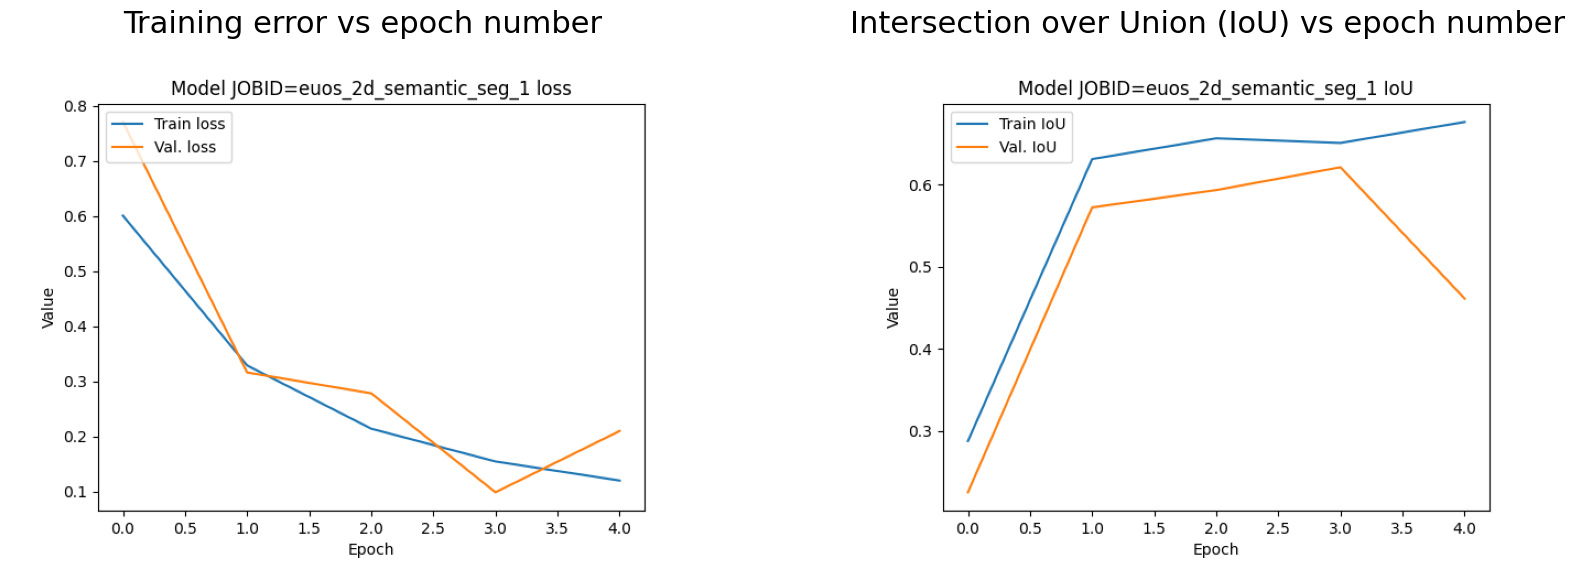

In [11]:
#@markdown ##Play the cell to show a plot of training error vs. epoch number and IoU vs epoch number
import matplotlib.pyplot as plt

loss_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_loss.png' )

iou_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_IoU.png' )

fig = plt.figure( figsize = (20,10))
ax1 = plt.subplot( 1, 2, 1 )
_ = plt.imshow( loss_plot )
_ = plt.axis('off')
ax1.set_title( 'Training error vs epoch number', fontdict = {'fontsize':22})

ax2 = plt.subplot( 1, 2, 2 )
_ = plt.imshow( iou_plot )
_ = plt.axis('off')
_= ax2.set_title( 'Intersection over Union (IoU) vs epoch number', fontdict = {'fontsize':22})

## **Visualize semantic segmentation results (from the test set)**
___

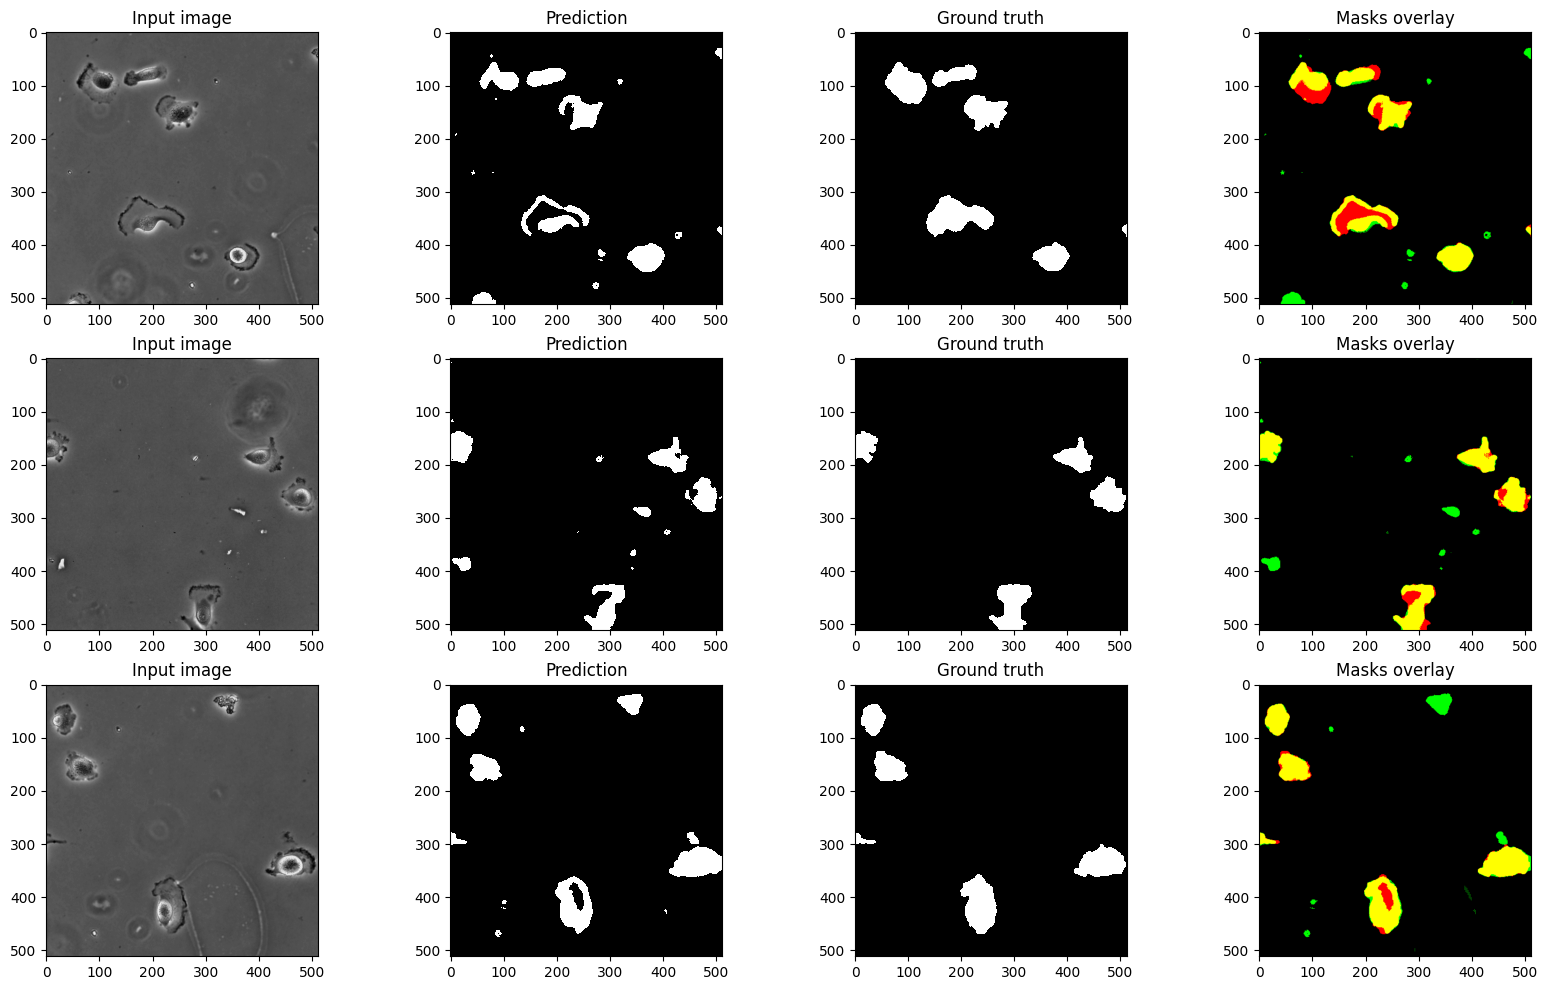

In [12]:
final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

if biapy_config['TEST']['FULL_IMG'] == True:
    semantic_results = os.path.join(final_results, "full_image_binarized")
else:
    semantic_results = os.path.join(final_results, "per_image_binarized")

#@markdown ##Play to visualize some results from the test set
#@markdown The results will be shown displaying:
#@markdown 1. The original **Input image**.
#@markdown 2. The model **Prediction** labels.
#@markdown 3. Its corresponding **Ground truth** labels.
#@markdown 4. The **Masks overlay** (true positive pixels in yellow, false negative pixels in red and false positive pixels in green).

from IPython.display import Markdown as md
md("After this last step, the resulting images should be placed in {}".format(final_results))
# Show a few examples to check that they have been stored correctly
%matplotlib inline
import matplotlib
import numpy as np
from numpy.random import randint, seed
from matplotlib import pyplot as plt

ids_pred = sorted(next(os.walk(semantic_results))[2])
ids_input = sorted(next(os.walk(test_data_path))[2])
ids_gt = sorted(next(os.walk(test_data_gt_path))[2])

samples_to_show = min(len(ids_input), 3)
chosen_images = np.random.choice(len(ids_input), samples_to_show, replace=False)
seed(1)

test_samples = []
test_sample_preds = []
test_sample_gt = []

for i in range(len(chosen_images)):
    aux = imread(os.path.join(test_data_path, ids_input[chosen_images[i]]))
    test_samples.append(aux)

    aux = imread(os.path.join(semantic_results, ids_pred[chosen_images[i]])).astype(np.uint16)
    test_sample_preds.append(aux)

    aux = imread(os.path.join(test_data_gt_path, ids_gt[chosen_images[i]])).astype(np.uint16)
    test_sample_gt.append(aux)

# Show predicted images
plt.figure(figsize=(20,12))
index = 1
for j in range(samples_to_show):
    plt.subplot(samples_to_show, 4, index)
    plt.title("Input image")
    plt.imshow(np.squeeze(test_samples[j]), cmap='gray')

    index = index + 1
    plt.subplot(samples_to_show, 4, index)
    plt.title("Prediction")
    plt.imshow(np.squeeze(test_sample_preds[j]), cmap='gray', interpolation='nearest')

    index = index + 1
    plt.subplot(samples_to_show, 4, index)
    plt.title("Ground truth")
    plt.imshow(np.squeeze(test_sample_gt[j]),  cmap='gray', interpolation='nearest')

    index = index + 1
    plt.subplot(samples_to_show, 4, index)
    plt.title("Masks overlay")
    b = np.zeros( test_sample_gt[j].shape )
    overlay = np.dstack( (test_sample_gt[j]>0, test_sample_preds[j]>0, b ))
    plt.imshow( overlay )

    index = index + 1
plt.show()


## **Export your model to BioImage Model Zoo format**
___
If you want to export the model into the [BioImage Model Zoo](https://bioimage.io/#/) format, fill the metadata and run the following cell. After the cell is run a `trained_model_name.bmz.zip` file will be downloaded.

In [13]:

#@markdown ##Construct model's metadata to export it to the BioImage Model Zoo format. Choose just one option:

#@markdown **Option 1: Reuse previous BioImage Model Zoo model configuration**

#@markdown With this option, if you were using a model from BioImage Model Zoo you can select this option to reuse its configuration instead of provide all fields manually. If that's not the case and you try to use this option an error will be thrown.
reuse_previous_BMZ_model_config = False #@param {type:"boolean"}

#@markdown ---

#@markdown **Option 2: Manual export fields**

#@markdown With this option you need to introduce manually the metadata of the model.

# ------------- User input ------------
# information about the model
trained_model_name    = "my_model_biapy" #@param {type:"string"}
trained_model_authors =  "[student1]" #@param {type:"string"}
trained_model_authors_github_user =  "[student1]" #@param {type:"string"}
trained_model_description = "Semantic segmentation model trained during EU OS Autumn School" #@param {type:"string"}
trained_model_license = 'CC-BY-4.0'#@param {type:"string"}
trained_model_references = ["Ronneberger et al. arXiv in 2015", "Franco-Barranco, Daniel, et al. ISBI in 2023"] #@param {type:"string"}
trained_model_references_DOI = ["10.1007/978-3-319-24574-4_28","10.1109/ISBI53787.2023.10230593"] #@param {type:"string"}
trained_model_tags = "[\"tag-1\", \"tag-2\"]" #@param {type:"string"}
trained_model_documentation = "/content/README.md" #@param {type:"string"}


In [14]:
# @markdown ###Play to download a zip file with your [BioImage Model Zoo](https://bioimage.io/#/) exported model

from google.colab import files
import zipfile
import os
import torch
import importlib.util
import sys
import yaml

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")
bmz_results = os.path.join(final_results, "bmz_model")

if not reuse_previous_BMZ_model_config:

    # create the author spec input
    auth_names = trained_model_authors[1:-1].split(",")
    auth_githubusers = trained_model_authors_github_user[1:-1].split(",")
    assert len(auth_names) == len(auth_githubusers)
    authors = [{"name": auth_name, "github_user": auth_guser} for auth_name, auth_guser in zip(auth_names, auth_githubusers)]

    # create the citation input spec
    assert len(trained_model_references_DOI) == len(trained_model_references)
    citations = [{'text': text, 'doi': doi} for text, doi in zip(trained_model_references, trained_model_references_DOI)]

    tags = [t for t in trained_model_tags.split(",")]

    with open(trained_model_documentation, "w") as f:
        f.write("### **Description**\n")
        f.write(f"{trained_model_description}\n\n")
        f.write("This model was created using the [BiaPy library](https://biapyx.github.io/).\n")

    bmz_cfg = {}
    # Description of the model
    bmz_cfg['description'] = trained_model_description
    # Authors of the model. Need to be a list of dicts, e.g. authors=[{"name": "Daniel", "github_user": "danifranco"}]
    bmz_cfg['authors'] = authors
    # License of the model. E.g. "CC-BY-4.0"
    bmz_cfg['license'] = trained_model_license
    # List of dictionaries of citations associated, e.g. [{"text": "Gizmo et al.", "doi": "doi:10.1002/xyzacab123"}]
    bmz_cfg['tags'] = tags
    # Tags to make models more findable on the website, e.g. tags=["electron-microscopy", "mitochondria"]
    bmz_cfg['cite'] = citations
    # Path to a file with a documentation of the model in markdown, e.g. "my-model/doc.md"
    bmz_cfg['doc'] = trained_model_documentation
    # Name of the model
    bmz_cfg["model_name"] = trained_model_name
    biapy.export_model_to_bmz(bmz_results, bmz_cfg)
else:
    try:
        biapy.export_model_to_bmz(bmz_results, reuse_original_bmz_config=True)
    except:
        print("Seems that the was a problem reusing BMZ model specs. Please uncheck 'reuse_previous_BMZ_model_config' and do it manually")


bmz_zip_path = f"/{bmz_results}/{trained_model_name}.zip"


# Define file paths
output_folder = f"{bmz_results}/unzipped"
# Create output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)
# Extract the zip file
with zipfile.ZipFile(bmz_zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_folder)



# Find the first .py file in the folder
script_files = [f for f in os.listdir(output_folder) if f.endswith('.py')]

weigths_name = [f for f in os.listdir(output_folder) if f.endswith('.pth')][0]

if not script_files:
    raise FileNotFoundError("No Python scripts found in the folder.")

script_name = script_files[0]  # Assuming there's only one .py file
script_path = os.path.join(output_folder, script_name)

# Dynamically import the script
spec = importlib.util.spec_from_file_location("dynamic_module", script_path)
dynamic_module = importlib.util.module_from_spec(spec)
sys.modules["dynamic_module"] = dynamic_module
spec.loader.exec_module(dynamic_module)

# Now you can use `dynamic_module` to access classes or functions
# Example: Instantiate a model and convert it to TorchScript
model = dynamic_module.U_Net(
        image_shape=(256, 256, 1),
        activation="elu",
        feature_maps=[16, 32, 64, 128, 256],
        drop_values=[0.0, 0.0, 0.0, 0.0, 0.0],
        normalization="bn",
        k_size=3,
        upsample_layer="convtranspose",
        z_down=[2, 2, 2, 2],
        n_classes=2,
        output_channels=None,
        upsampling_factor=(),
        upsampling_position="pre",
        )

# Load the weights
weights_path = f"{output_folder}/{weigths_name}"

state_dict = torch.load(weights_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict['model'])

# Convert to TorchScript
model.eval()
dummy_input = torch.randn(1, 1, 256, 256)  # Adjust dimensions as per your model's input

# Trace the model
torchscript_model = torch.jit.trace(model, dummy_input)

# Save the TorchScript model
output_path = f"{output_folder}/torchscript.pt"
torch.jit.save(torchscript_model, output_path)



# Define the path to your YAML file
file_path = f"{output_folder}/rdf.yaml"

# Open and load the YAML file
with open(file_path, "r") as file:
    data = yaml.safe_load(file)
torchscript_dict = {}
torchscript_dict["pytorch_version"] = "2.0.0"
torchscript_dict["source"] = "torchscript.pt"

data["weights"]["torchscript"] = torchscript_dict

with open(file_path, "w") as file:
    yaml.dump(data, file, default_flow_style=False)



# Create a zip file
with zipfile.ZipFile(bmz_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through all files and directories in the output_folder
    for root, dirs, file_list in os.walk(output_folder):
        for file in file_list:
            # Get the full path of the file
            file_path = os.path.join(root, file)
            # Add file to the zip (relative path for proper folder structure)
            arcname = os.path.relpath(file_path, output_folder)
            zipf.write(file_path, arcname)


download = True


if download and os.path.exists(bmz_zip_path):
    files.download(bmz_zip_path)


computing SHA256 of test-input.npy (result: aa6f05c5406476e856ce0d8147b58b38a2e373085b05739476af4b205161248d): 100%|██████████| 262272/262272 [00:00<00:00, 77348368.63it/s] 
computing SHA256 of test-output.npy (result: 12e4bb0807366899a28e69c676411f720ffed82fe5c50380285a87a1682aa94e): 100%|██████████| 262272/262272 [00:00<00:00, 61297698.58it/s]
computing SHA256 of unet.py (result: 8d5ff7f0a9af85d6f6bd85a0ea5c10b9b51efbb3330a0a71abf2e5493fb55199): 100%|██████████| 7915/7915 [00:00<00:00, 3279778.32it/s] 
computing SHA256 of euos_2d_semantic_seg_1-checkpoint-best.pth (result: dc90fabcea6f24d5bbb914c762bd5d0e83a8f55e80f5706d81b6018c96671b5a): 100%|██████████| 23504944/23504944 [00:00<00:00, 219937759.23it/s]
2024-11-27 02:24:36.433 | Level 30 | bioimageio.spec.model.v0_5:_validate_documentation:2106 - documentation: No '# Validation' (sub)section found in /content/README.md.
/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_serializers.py:42: UserWarning: Pydantic serializer wa

[02:24:36.626712] Created 'my_model_biapy'


computing SHA256 of test-input.npy (result: aa6f05c5406476e856ce0d8147b58b38a2e373085b05739476af4b205161248d):   0%|          | 0/262272 [00:00<?, ?it/s]
computing SHA256 of test-output.npy (result: 12e4bb0807366899a28e69c676411f720ffed82fe5c50380285a87a1682aa94e):   0%|          | 0/262272 [00:00<?, ?it/s]
computing SHA256 of unet.py (result: 8d5ff7f0a9af85d6f6bd85a0ea5c10b9b51efbb3330a0a71abf2e5493fb55199):   0%|          | 0/7915 [00:00<?, ?it/s]
computing SHA256 of euos_2d_semantic_seg_1-checkpoint-best.pth (result: dc90fabcea6f24d5bbb914c762bd5d0e83a8f55e80f5706d81b6018c96671b5a):   0%|          | 0/23504944 [00:00<?, ?it/s]


[02:24:38.307800] Package path: /content/output/euos_2d_semantic_seg/results/euos_2d_semantic_seg_1/bmz_model/my_model_biapy.zip
[02:24:38.309408] FINISHED JOB euos_2d_semantic_seg_1 !!


<ipython-input-14-5495f103f9b3>:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=torch.device('cpu'))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Acknowledgments**
___
We extend our gratitude to the [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki) for their invaluable inspiration. Notably, we have adopted some of their descriptions concerning metrics and parameters.